In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)

In [2]:
# Read pre-processed data
adata_train = sc.read_h5ad('../../data/GSE_158055_COVID19_TRAIN.h5ad')
adata_test = sc.read_h5ad('../../data/GSE_158055_COVID19_TEST.h5ad')

# Concatenate the train and test adata into one adata.
adata_concat = adata_train.concatenate(adata_test, batch_categories=['ref', 'new'])
adata = adata_concat.copy()

del adata_concat

/home/dozonok/anaconda3/envs/workshop_scanpy_2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


### Get centroids of each samples

In [3]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sampleID_label'].values
#covid_non_covid_vector = adata.obs['covid_non_covid'].values
batch_vector = adata.obs['batch'].values

x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, batch_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'batch', 'x_basis_value', 'y_basis_value'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

del basis_values
del sample_vector
del batch_vector
del x_basis_value
del y_basis_value


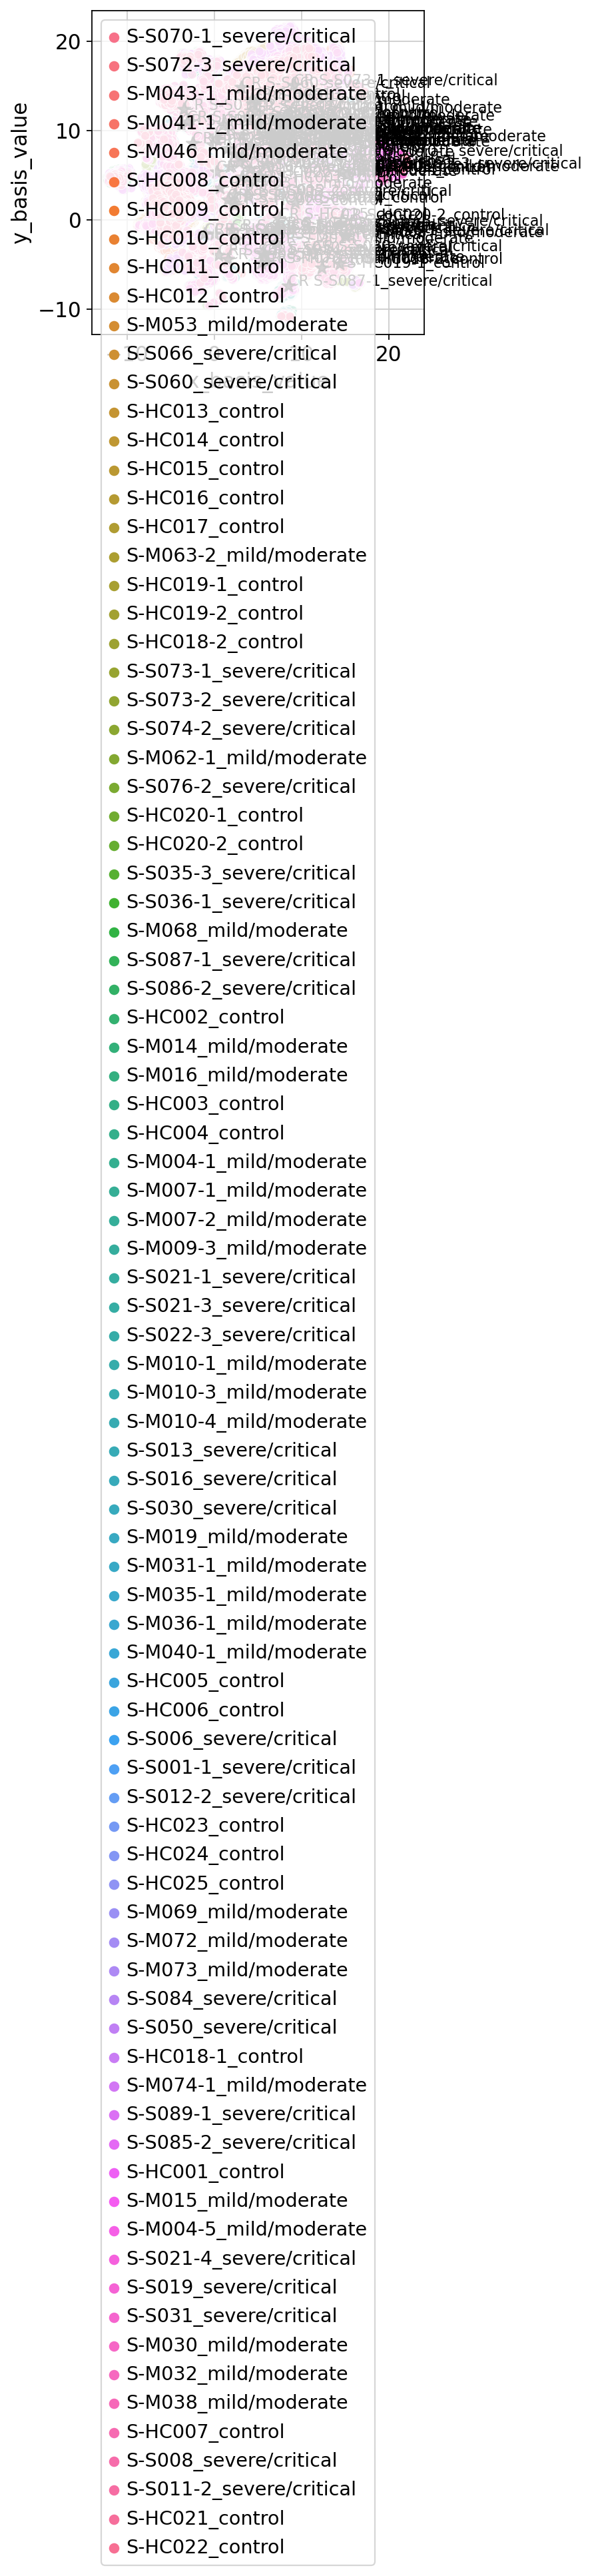

In [4]:
list_samples = df['sample'].unique()
sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', alpha=0.8)
#sns.lmplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color='black')
    plt.text(centroid[0], centroid[1], f'CR {list_samples[centroid_id]}', color='black', fontsize=10)
    centroid_id+= 1

# Show the plot
sc.set_figure_params(figsize=(25, 25))
plt.legend(loc="upper left")
plt.show()

In [5]:
# from sklearn.model_selection import train_test_split

# y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=7777)
y_train = np.unique(df.query("batch == 'ref'")['sample'].values)
y_test = np.unique(df.query("batch == 'new'")['sample'].values)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test) 
print()
print("Length of train samples:", len(y_train))
print("Length of test samples:", len(y_test))

Samples for getting centroids of existing samples (covid and non-covid): ['S-HC002_control' 'S-HC003_control' 'S-HC004_control' 'S-HC005_control'
 'S-HC006_control' 'S-HC008_control' 'S-HC009_control' 'S-HC010_control'
 'S-HC011_control' 'S-HC012_control' 'S-HC013_control' 'S-HC014_control'
 'S-HC015_control' 'S-HC016_control' 'S-HC017_control' 'S-HC018-2_control'
 'S-HC019-1_control' 'S-HC019-2_control' 'S-HC020-1_control'
 'S-HC020-2_control' 'S-HC023_control' 'S-HC024_control' 'S-HC025_control'
 'S-M004-1_mild/moderate' 'S-M007-1_mild/moderate'
 'S-M007-2_mild/moderate' 'S-M009-3_mild/moderate'
 'S-M010-1_mild/moderate' 'S-M010-3_mild/moderate'
 'S-M010-4_mild/moderate' 'S-M014_mild/moderate' 'S-M016_mild/moderate'
 'S-M019_mild/moderate' 'S-M031-1_mild/moderate' 'S-M035-1_mild/moderate'
 'S-M036-1_mild/moderate' 'S-M040-1_mild/moderate'
 'S-M041-1_mild/moderate' 'S-M043-1_mild/moderate' 'S-M046_mild/moderate'
 'S-M053_mild/moderate' 'S-M062-1_mild/moderate' 'S-M063-2_mild/moderate'

<s>## Sample Classification: Scenario 3.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Run kmeans clusterning and get clusters. Encode exsting samples (covid and non-covid) clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of </s>


In [6]:
umap1 = adata.obsm['X_umap'][:, 0]
umap2 = adata.obsm['X_umap'][:, 1]
sample_vector = adata.obs['sampleID_label'].values

df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)),
               columns =['umap1', 'umap2', 'sample'])
df

,umap1,umap2,sample
0,-3.312607,-5.609095,S-S070-1_severe/critical
1,10.491699,3.347641,S-S070-1_severe/critical
2,1.812781,-5.535585,S-S070-1_severe/critical
3,-3.287290,-5.597246,S-S070-1_severe/critical
4,1.797183,-5.635811,S-S070-1_severe/critical
...,...,...,...
485663,11.576544,13.771201,S-HC022_control
485664,-3.989010,1.123159,S-HC022_control
485665,3.758349,12.195270,S-HC022_control
485666,9.901998,14.476457,S-HC022_control


In [7]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

,umap1,umap2,sample,covid_non_covid
0,-3.312607,-5.609095,S-S070-1_severe/critical,covid
1,10.491699,3.347641,S-S070-1_severe/critical,covid
2,1.812781,-5.535585,S-S070-1_severe/critical,covid
3,-3.287290,-5.597246,S-S070-1_severe/critical,covid
4,1.797183,-5.635811,S-S070-1_severe/critical,covid
...,...,...,...,...
485663,11.576544,13.771201,S-HC022_control,non_covid
485664,-3.989010,1.123159,S-HC022_control,non_covid
485665,3.758349,12.195270,S-HC022_control,non_covid
485666,9.901998,14.476457,S-HC022_control,non_covid


#### Split the dataset into train: df_exist and test: df_new

In [8]:
# Make a dataframe for training
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
df_exist

,umap1,umap2,sample,covid_non_covid
0,-3.312607,-5.609095,S-S070-1_severe/critical,covid
1,10.491699,3.347641,S-S070-1_severe/critical,covid
2,1.812781,-5.535585,S-S070-1_severe/critical,covid
3,-3.287290,-5.597246,S-S070-1_severe/critical,covid
4,1.797183,-5.635811,S-S070-1_severe/critical,covid
...,...,...,...,...
378607,5.408503,5.839364,S-S050_severe/critical,covid
378608,-0.224561,0.965278,S-S050_severe/critical,covid
378609,5.803615,6.101612,S-S050_severe/critical,covid
378610,-0.084627,0.956722,S-S050_severe/critical,covid


In [9]:
# Make a dataframe for testing
y_test = list(y_test)
df_new = df.query("sample == @y_test")
df_new

,umap1,umap2,sample,covid_non_covid
378612,12.537815,-6.335041,S-HC018-1_control,non_covid
378613,12.948494,-6.377243,S-HC018-1_control,non_covid
378614,-5.356986,5.326135,S-HC018-1_control,non_covid
378615,12.369816,-5.876509,S-HC018-1_control,non_covid
378616,12.184783,-5.065311,S-HC018-1_control,non_covid
...,...,...,...,...
485663,11.576544,13.771201,S-HC022_control,non_covid
485664,-3.989010,1.123159,S-HC022_control,non_covid
485665,3.758349,12.195270,S-HC022_control,non_covid
485666,9.901998,14.476457,S-HC022_control,non_covid


### Run Kmeans clusterning to get clusters' centroids as a cluster representation.

Also, check the elbow to determine the number of clusters (the parameter `k`).

In [10]:
from sklearn.cluster import KMeans
sc.set_figure_params(figsize=None)

data = (df_exist[['umap1', 'umap2']])
inertias = []

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
Y

KeyboardInterrupt: 

According to the above plot, we shall use `k=3` this time.<br>
<br>

Next, train a kmeans again with `k=4`, and get distances between each centroid and each sample, and then append them to the dataframe.

XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None
XX: None
YY: None


/tmp/ipykernel_291354/546879023.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/546879023.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/546879023.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<AxesSubplot:xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

/home/dozonok/anaconda3/envs/workshop_scanpy_2/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


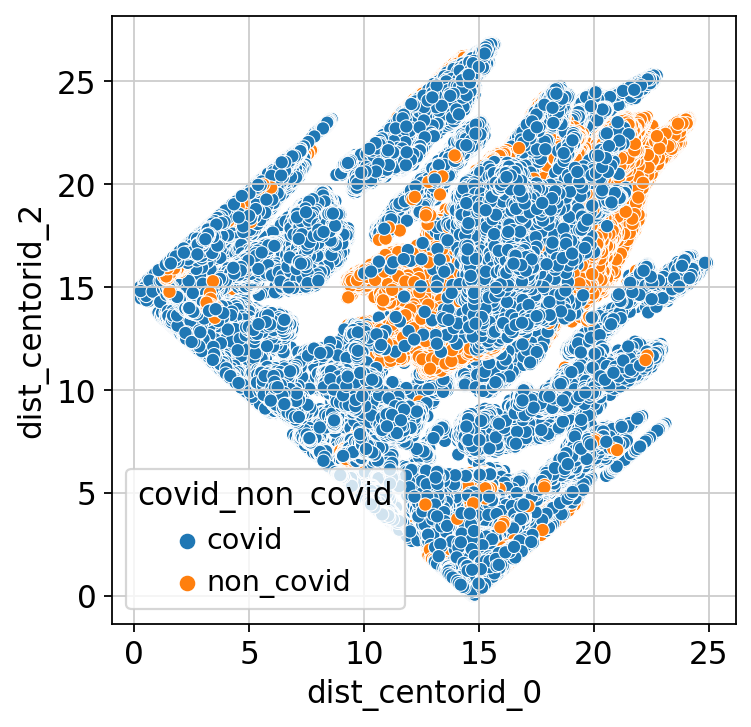

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
centroids = kmeans.cluster_centers_

### Compute a distance
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

Also, print the augmented dataframe.

In [12]:
df_exist

,umap1,umap2,sample,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3
0,-3.312607,-5.609095,S-S070-1_severe/critical,covid,13.394956,20.540241,8.204026,24.020674
1,10.491699,3.347641,S-S070-1_severe/critical,covid,5.750886,12.617297,14.754791,8.611382
2,1.812781,-5.535585,S-S070-1_severe/critical,covid,8.488179,19.398816,10.094570,20.645136
3,-3.287290,-5.597246,S-S070-1_severe/critical,covid,13.367516,20.520758,8.195161,23.994371
4,1.797183,-5.635811,S-S070-1_severe/critical,covid,8.540746,19.499991,10.165677,20.736069
...,...,...,...,...,...,...,...,...
378607,5.408503,5.839364,S-S050_severe/critical,covid,9.231806,8.202033,10.197345,9.959367
378608,-0.224561,0.965278,S-S050_severe/critical,covid,10.442004,13.338721,4.315006,17.372932
378609,5.803615,6.101612,S-S050_severe/critical,covid,9.293527,8.055835,10.656707,9.485145
378610,-0.084627,0.956722,S-S050_severe/critical,covid,10.306641,13.309427,4.448597,17.265988


Train the augmented dataset in SVM

In [13]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['sample', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

Print the dataframe for the test data/new samples

In [14]:
df_new

,umap1,umap2,sample,covid_non_covid
378612,12.537815,-6.335041,S-HC018-1_control,non_covid
378613,12.948494,-6.377243,S-HC018-1_control,non_covid
378614,-5.356986,5.326135,S-HC018-1_control,non_covid
378615,12.369816,-5.876509,S-HC018-1_control,non_covid
378616,12.184783,-5.065311,S-HC018-1_control,non_covid
...,...,...,...,...
485663,11.576544,13.771201,S-HC022_control,non_covid
485664,-3.989010,1.123159,S-HC022_control,non_covid
485665,3.758349,12.195270,S-HC022_control,non_covid
485666,9.901998,14.476457,S-HC022_control,non_covid


In [15]:
# Get distance between a new sample and existing centroids
for i in range(len(centroids)):
    cur_centroid = np.array(centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['sample', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred


/tmp/ipykernel_291354/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/518162624.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [16]:
df_new

,umap1,umap2,sample,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3,y_pred
378612,12.537815,-6.335041,S-HC018-1_control,non_covid,4.908275,22.100353,18.982559,17.706931,non_covid
378613,12.948494,-6.377243,S-HC018-1_control,non_covid,5.191022,22.311087,19.365917,17.726518,non_covid
378614,-5.356986,5.326135,S-HC018-1_control,non_covid,16.879728,12.197345,2.999232,19.996325,non_covid
378615,12.369816,-5.876509,S-HC018-1_control,non_covid,4.439629,21.613384,18.622495,17.261730,non_covid
378616,12.184783,-5.065311,S-HC018-1_control,non_covid,3.698374,20.799060,18.102043,16.469295,non_covid
...,...,...,...,...,...,...,...,...,...
485663,11.576544,13.771201,S-HC022_control,non_covid,16.228046,8.157076,19.398134,3.243966,non_covid
485664,-3.989010,1.123159,S-HC022_control,non_covid,14.100972,14.679975,1.441279,20.437647,covid
485665,3.758349,12.195270,S-HC022_control,non_covid,15.699808,1.636765,12.536842,9.994837,non_covid
485666,9.901998,14.476457,S-HC022_control,non_covid,16.823425,6.518046,18.505485,4.942598,non_covid


In [17]:
pred_label_count = {key: [0, 0,]for key in df_new['sample'].unique()} # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if 'covid' == row['y_pred']:
        pred_label_count[row['sample']][0] += 1
    else:
        pred_label_count[row['sample']][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]: #counts of covid > counts of non_covid
        y_pred.append('covid')
    else:
        y_pred.append('non_covid')
    
    if "mild/moderate" in sample or "severe/critical" in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'S-HC018-1_control': [312, 2218], 'S-M074-1_mild/moderate': [2878, 154], 'S-S089-1_severe/critical': [1730, 204], 'S-S085-2_severe/critical': [4263, 8329], 'S-HC001_control': [4162, 4605], 'S-M015_mild/moderate': [8439, 523], 'S-M004-5_mild/moderate': [9143, 82], 'S-S021-4_severe/critical': [4222, 60], 'S-S019_severe/critical': [5422, 277], 'S-S031_severe/critical': [3753, 2213], 'S-M030_mild/moderate': [7245, 1804], 'S-M032_mild/moderate': [3514, 4344], 'S-M038_mild/moderate': [4604, 3804], 'S-HC007_control': [753, 6321], 'S-S008_severe/critical': [549, 30], 'S-S011-2_severe/critical': [273, 0], 'S-HC021_control': [2251, 3715], 'S-HC022_control': [3136, 1724]}


In [18]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.3333333333333333
Precision: 0.3333333333333333
Recall: 0.3333333333333333


## Sample Classification: Scenario 3.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [11]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sampleID_label'].values
#covid_non_covid_vector = adata.obs['covid_non_covid'].values
batch_vector = adata.obs['batch'].values

x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, batch_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'batch', 'umap1', 'umap2'])

del basis_values
del sample_vector
del batch_vector
del x_basis_value
del y_basis_value


In [12]:
# from sklearn.model_selection import train_test_split

# y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=7777)
y_train = np.unique(df.query("batch == 'ref'")['sample'].values)
y_test = np.unique(df.query("batch == 'new'")['sample'].values)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test) 
print()
print("Length of train samples:", len(y_train))
print("Length of test samples:", len(y_test))

Samples for getting centroids of existing samples (covid and non-covid): ['S-HC002_control' 'S-HC003_control' 'S-HC004_control' 'S-HC005_control'
 'S-HC006_control' 'S-HC008_control' 'S-HC009_control' 'S-HC010_control'
 'S-HC011_control' 'S-HC012_control' 'S-HC013_control' 'S-HC014_control'
 'S-HC015_control' 'S-HC016_control' 'S-HC017_control' 'S-HC018-2_control'
 'S-HC019-1_control' 'S-HC019-2_control' 'S-HC020-1_control'
 'S-HC020-2_control' 'S-HC023_control' 'S-HC024_control' 'S-HC025_control'
 'S-M004-1_mild/moderate' 'S-M007-1_mild/moderate'
 'S-M007-2_mild/moderate' 'S-M009-3_mild/moderate'
 'S-M010-1_mild/moderate' 'S-M010-3_mild/moderate'
 'S-M010-4_mild/moderate' 'S-M014_mild/moderate' 'S-M016_mild/moderate'
 'S-M019_mild/moderate' 'S-M031-1_mild/moderate' 'S-M035-1_mild/moderate'
 'S-M036-1_mild/moderate' 'S-M040-1_mild/moderate'
 'S-M041-1_mild/moderate' 'S-M043-1_mild/moderate' 'S-M046_mild/moderate'
 'S-M053_mild/moderate' 'S-M062-1_mild/moderate' 'S-M063-2_mild/moderate'

In [13]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

,basis_value,sample,batch,umap1,umap2,covid_non_covid
0,"[-3.3126068, -5.609095]",S-S070-1_severe/critical,ref,-3.312607,-5.609095,covid
1,"[10.491699, 3.3476408]",S-S070-1_severe/critical,ref,10.491699,3.347641,covid
2,"[1.8127815, -5.535585]",S-S070-1_severe/critical,ref,1.812781,-5.535585,covid
3,"[-3.2872899, -5.5972457]",S-S070-1_severe/critical,ref,-3.287290,-5.597246,covid
4,"[1.7971826, -5.635811]",S-S070-1_severe/critical,ref,1.797183,-5.635811,covid
...,...,...,...,...,...,...
485663,"[11.576544, 13.771201]",S-HC022_control,new,11.576544,13.771201,non_covid
485664,"[-3.98901, 1.123159]",S-HC022_control,new,-3.989010,1.123159,non_covid
485665,"[3.7583492, 12.19527]",S-HC022_control,new,3.758349,12.195270,non_covid
485666,"[9.901998, 14.476457]",S-HC022_control,new,9.901998,14.476457,non_covid


In [14]:
# Get a centroid of each sample: exist (train)
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

# Get a centroid of each sample: new (test)
X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

# Make covid_non_covid column
list_covid_non_covid = []
for index, row in df_exist.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_exist['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in df_new.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_new['covid_non_covid'] = list_covid_non_covid

/tmp/ipykernel_2796382/3195633003.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['covid_non_covid'] = list_covid_non_covid
/tmp/ipykernel_2796382/3195633003.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['covid_non_covid'] = list_covid_non_covid


In [15]:
df_exist

,basis_value,sample,batch,umap1,umap2,covid_non_covid
0,"[-3.3126068, -5.609095]",S-S070-1_severe/critical,ref,-3.312607,-5.609095,covid
1,"[10.491699, 3.3476408]",S-S070-1_severe/critical,ref,10.491699,3.347641,covid
2,"[1.8127815, -5.535585]",S-S070-1_severe/critical,ref,1.812781,-5.535585,covid
3,"[-3.2872899, -5.5972457]",S-S070-1_severe/critical,ref,-3.287290,-5.597246,covid
4,"[1.7971826, -5.635811]",S-S070-1_severe/critical,ref,1.797183,-5.635811,covid
...,...,...,...,...,...,...
378607,"[5.4085026, 5.839364]",S-S050_severe/critical,ref,5.408503,5.839364,covid
378608,"[-0.22456056, 0.96527815]",S-S050_severe/critical,ref,-0.224561,0.965278,covid
378609,"[5.803615, 6.1016116]",S-S050_severe/critical,ref,5.803615,6.101612,covid
378610,"[-0.08462662, 0.95672226]",S-S050_severe/critical,ref,-0.084627,0.956722,covid


/tmp/ipykernel_2796382/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2796382/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2796382/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

<AxesSubplot:xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

/home/dozonok/anaconda3/envs/workshop_scanpy_2/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


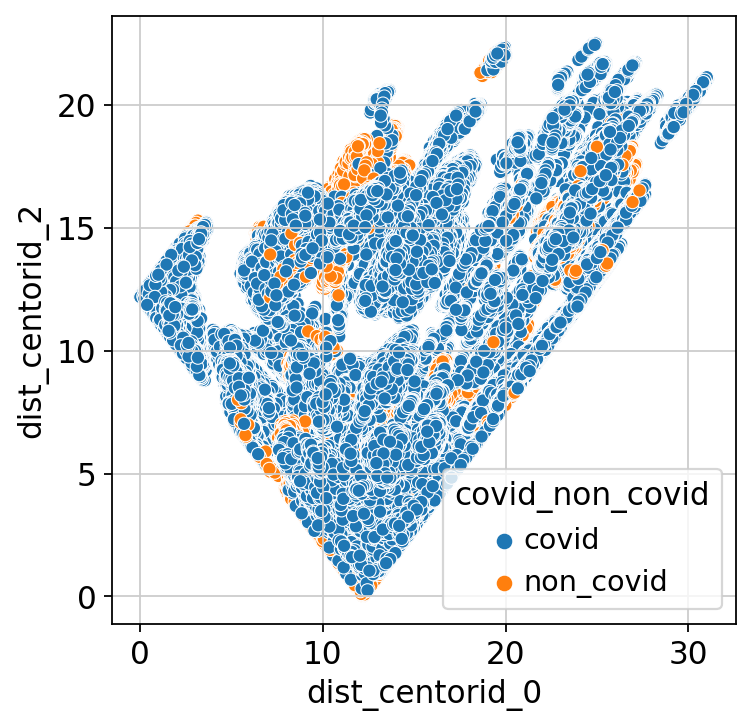

In [16]:
### Compute a distance
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

In [17]:
from sklearn.svm import SVC

# Prepare training data for building the model
X_train = df_exist.drop(['basis_value', 'sample', 'batch', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

In [18]:
# Get distance between a new sample and existing centroids
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['basis_value', 'sample', 'batch', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred

/tmp/ipykernel_2796382/2822192288.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2796382/2822192288.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_2796382/2822192288.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [19]:
#y_true = y_test.to_list()

In [81]:
df_new

,basis_value,sample,batch,umap1,umap2,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3,...,dist_centorid_61,dist_centorid_62,dist_centorid_63,dist_centorid_64,dist_centorid_65,dist_centorid_66,dist_centorid_67,dist_centorid_68,dist_centorid_69,y_pred
378612,"[12.537815, -6.335041]",S-HC018-1_control,new,12.537815,-6.335041,non_covid,13.593887,18.738845,18.127355,15.564968,...,12.287285,8.158145,10.838458,20.096798,21.200107,20.937422,18.210384,24.624177,14.466382,non_covid
378613,"[12.948494, -6.377243]",S-HC018-1_control,new,12.948494,-6.377243,non_covid,13.449843,18.869188,18.280000,15.743820,...,12.698419,8.514867,11.234074,20.387081,21.523168,21.139195,18.351425,24.925240,14.868524,non_covid
378614,"[-5.356986, 5.326135]",S-HC018-1_control,new,-5.356986,5.326135,non_covid,24.092568,15.525109,14.369280,13.153279,...,10.965982,13.228682,10.869666,6.784313,4.314869,12.376621,14.923277,7.269502,8.110337,non_covid
378615,"[12.369816, -5.876509]",S-HC018-1_control,new,12.369816,-5.876509,non_covid,13.267104,18.255610,17.640845,15.076705,...,12.040894,7.753469,10.512073,19.633681,20.759128,20.449670,17.725392,24.167387,14.162485,non_covid
378616,"[12.184783, -5.0653114]",S-HC018-1_control,new,12.184783,-5.065311,non_covid,12.655991,17.423746,16.809482,14.249889,...,11.754133,7.160073,10.074422,18.889327,20.066471,19.631116,16.893388,23.437303,13.759622,non_covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485663,"[11.576544, 13.771201]",S-HC022_control,new,11.576544,13.771201,non_covid,10.736867,3.412031,4.612998,6.802983,...,20.911526,16.205170,18.293456,12.316245,15.026740,7.232138,4.071672,15.139292,19.939999,covid
485664,"[-3.98901, 1.123159]",S-HC022_control,new,-3.989010,1.123159,non_covid,23.190066,16.682305,15.462347,13.532615,...,6.766929,10.320522,7.302564,9.226629,7.601346,14.496653,15.991716,11.241101,3.945248,covid
485665,"[3.7583492, 12.19527]",S-HC022_control,new,3.758349,12.195270,non_covid,16.295244,4.906799,4.150487,5.307682,...,16.479319,13.825877,14.383974,4.629478,7.248783,0.986566,4.602521,7.256292,14.631785,non_covid
485666,"[9.901998, 14.476457]",S-HC022_control,new,9.901998,14.476457,non_covid,12.403076,2.771317,3.942559,6.583460,...,20.698893,16.392657,18.169880,11.070311,13.754742,5.717950,3.499395,13.565373,19.494209,non_covid


In [20]:
pred_label_count = {key: [0, 0,]for key in df_new['sample'].unique()} # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if 'covid' == row['y_pred']:
        pred_label_count[row['sample']][0] += 1
    else:
        pred_label_count[row['sample']][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]: #counts of covid > counts of non_covid
        y_pred.append('covid')
    else:
        y_pred.append('non_covid')
    
    if "mild/moderate" in sample or "severe/critical" in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'S-HC018-1_control': [300, 2230], 'S-M074-1_mild/moderate': [2572, 460], 'S-S089-1_severe/critical': [1647, 287], 'S-S085-2_severe/critical': [4308, 8284], 'S-HC001_control': [4158, 4609], 'S-M015_mild/moderate': [8428, 534], 'S-M004-5_mild/moderate': [9142, 83], 'S-S021-4_severe/critical': [4229, 53], 'S-S019_severe/critical': [5610, 89], 'S-S031_severe/critical': [4531, 1435], 'S-M030_mild/moderate': [7370, 1679], 'S-M032_mild/moderate': [3618, 4240], 'S-M038_mild/moderate': [4662, 3746], 'S-HC007_control': [703, 6371], 'S-S008_severe/critical': [543, 36], 'S-S011-2_severe/critical': [273, 0], 'S-HC021_control': [2297, 3669], 'S-HC022_control': [3254, 1606]}


In [21]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 0.8333333333333334


## Sample Classification: Scenario 3.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get clusters as well as a centroid of covid and non_covid in UMAP representation. Encode two sample clusters into further by Euclidian distance between those centroids. Apply some linear classifier to train. Count the label prediction of a new sample because it’s encoded into distance expression, so that it derives how many cells are close with each exciting cluster/samples (covid or non-covid). 

This implementation is the same as this paper: 
A study on using data clustering for feature extraction to improve the quality of classification


In [65]:
basis_values = adata.obsm['X_umap']
sample_vector = adata.obs['sampleID_label'].values
#covid_non_covid_vector = adata.obs['covid_non_covid'].values
batch_vector = adata.obs['batch'].values

x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, batch_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'batch', 'umap1', 'umap2'])
df.head()
del basis_values
del sample_vector
del batch_vector
del x_basis_value
del y_basis_value


X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

In [66]:
# umap1 = adata.obsm['X_umap'][:, 0]
# umap2 = adata.obsm['X_umap'][:, 1]
# sample_vector = adata.obs['sample'].values

# df = pd.DataFrame(list(zip(umap1, umap2, sample_vector)),
#                columns =['umap1', 'umap2', 'sample'])
# df

In [67]:
list_covid_non_covid = []
for index, row in df.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df['covid_non_covid'] = list_covid_non_covid
df

,basis_value,sample,batch,umap1,umap2,covid_non_covid
0,"[-3.3126068, -5.609095]",S-S070-1_severe/critical,ref,-3.312607,-5.609095,covid
1,"[10.491699, 3.3476408]",S-S070-1_severe/critical,ref,10.491699,3.347641,covid
2,"[1.8127815, -5.535585]",S-S070-1_severe/critical,ref,1.812781,-5.535585,covid
3,"[-3.2872899, -5.5972457]",S-S070-1_severe/critical,ref,-3.287290,-5.597246,covid
4,"[1.7971826, -5.635811]",S-S070-1_severe/critical,ref,1.797183,-5.635811,covid
...,...,...,...,...,...,...
485663,"[11.576544, 13.771201]",S-HC022_control,new,11.576544,13.771201,non_covid
485664,"[-3.98901, 1.123159]",S-HC022_control,new,-3.989010,1.123159,non_covid
485665,"[3.7583492, 12.19527]",S-HC022_control,new,3.758349,12.195270,non_covid
485666,"[9.901998, 14.476457]",S-HC022_control,new,9.901998,14.476457,non_covid


In [68]:
y_train = np.unique(df.query("batch == 'ref'")['sample'].values)
y_test = np.unique(df.query("batch == 'new'")['sample'].values)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test) 
print()
print("Length of train samples:", len(y_train))
print("Length of test samples:", len(y_test))

Samples for getting centroids of existing samples (covid and non-covid): ['S-HC002_control' 'S-HC003_control' 'S-HC004_control' 'S-HC005_control'
 'S-HC006_control' 'S-HC008_control' 'S-HC009_control' 'S-HC010_control'
 'S-HC011_control' 'S-HC012_control' 'S-HC013_control' 'S-HC014_control'
 'S-HC015_control' 'S-HC016_control' 'S-HC017_control' 'S-HC018-2_control'
 'S-HC019-1_control' 'S-HC019-2_control' 'S-HC020-1_control'
 'S-HC020-2_control' 'S-HC023_control' 'S-HC024_control' 'S-HC025_control'
 'S-M004-1_mild/moderate' 'S-M007-1_mild/moderate'
 'S-M007-2_mild/moderate' 'S-M009-3_mild/moderate'
 'S-M010-1_mild/moderate' 'S-M010-3_mild/moderate'
 'S-M010-4_mild/moderate' 'S-M014_mild/moderate' 'S-M016_mild/moderate'
 'S-M019_mild/moderate' 'S-M031-1_mild/moderate' 'S-M035-1_mild/moderate'
 'S-M036-1_mild/moderate' 'S-M040-1_mild/moderate'
 'S-M041-1_mild/moderate' 'S-M043-1_mild/moderate' 'S-M046_mild/moderate'
 'S-M053_mild/moderate' 'S-M062-1_mild/moderate' 'S-M063-2_mild/moderate'

In [69]:
# Get a centroid of each sample: exist (train)
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

# Get a centroid of each sample: new (test)
X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

# Make covid_non_covid column
list_covid_non_covid = []
for index, row in df_exist.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_exist['covid_non_covid'] = list_covid_non_covid

list_covid_non_covid = []
for index, row in df_new.iterrows():
     if "mild/moderate" in row['sample'] or "severe/critical" in row['sample']:
          list_covid_non_covid.append('covid')
     else:
          list_covid_non_covid.append('non_covid')

df_new['covid_non_covid'] = list_covid_non_covid

/tmp/ipykernel_291354/3195633003.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['covid_non_covid'] = list_covid_non_covid
/tmp/ipykernel_291354/3195633003.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['covid_non_covid'] = list_covid_non_covid


/tmp/ipykernel_291354/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/245684153.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

<AxesSubplot:xlabel='dist_centorid_0', ylabel='dist_centorid_2'>

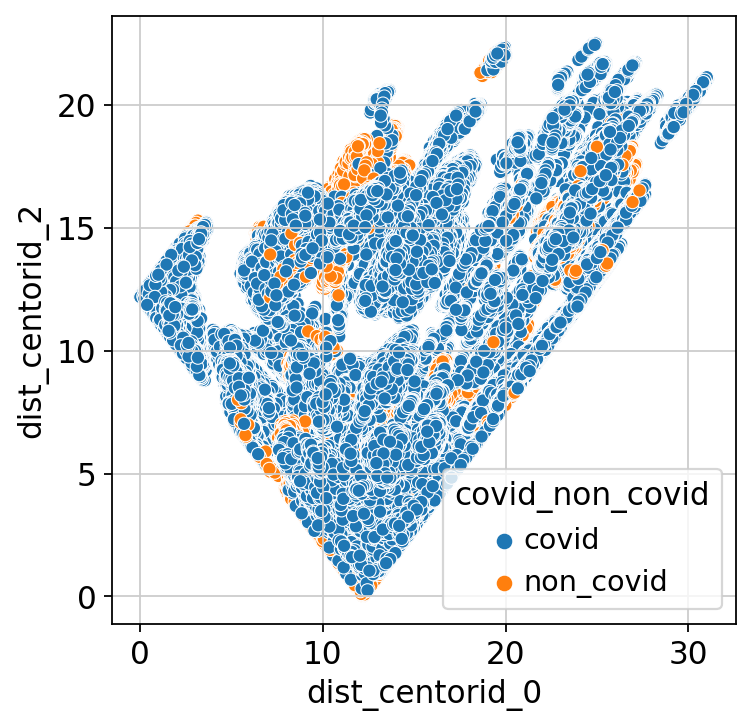

In [70]:
### Compute a distance
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_exist.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_exist[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Plot the result of the transformation in distance between each sample and centroids
sc.set_figure_params(figsize=(5, 5))
sns.scatterplot(data=df_exist, x="dist_centorid_0", y="dist_centorid_2", hue='covid_non_covid')

In [71]:
df_exist

,basis_value,sample,batch,umap1,umap2,covid_non_covid,dist_centorid_0,dist_centorid_1,dist_centorid_2,dist_centorid_3,...,dist_centorid_60,dist_centorid_61,dist_centorid_62,dist_centorid_63,dist_centorid_64,dist_centorid_65,dist_centorid_66,dist_centorid_67,dist_centorid_68,dist_centorid_69
0,"[-3.3126068, -5.609095]",S-S070-1_severe/critical,ref,-3.312607,-5.609095,covid,24.805941,21.293120,20.100591,17.636392,...,17.424249,4.140410,10.206436,6.809269,15.397899,14.213250,20.096557,20.564708,17.963487,4.568382
1,"[10.491699, 3.3476408]",S-S070-1_severe/critical,ref,10.491699,3.347641,covid,8.587381,8.842335,8.266811,5.878269,...,5.806347,12.389655,6.565225,9.655733,12.071609,14.030689,11.378494,8.321986,16.636301,12.629549
2,"[1.8127815, -5.535585]",S-S070-1_severe/critical,ref,1.812781,-5.535585,covid,20.346190,18.823988,17.724875,15.001658,...,14.797735,2.065215,5.857191,3.476165,15.054212,14.769587,18.666833,18.104806,18.660203,4.917705
3,"[-3.2872899, -5.5972457]",S-S070-1_severe/critical,ref,-3.287290,-5.597246,covid,24.778009,21.269090,20.076746,17.611570,...,17.399428,4.112468,10.178488,6.781449,15.380814,14.200039,20.075917,20.540649,17.951915,4.545908
4,"[1.7971826, -5.635811]",S-S070-1_severe/critical,ref,1.797183,-5.635811,covid,20.414969,18.923033,17.824516,15.100437,...,14.896603,2.133234,5.938640,3.577433,15.151957,14.860874,18.768253,18.203996,18.751899,4.989193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378607,"[5.4085026, 5.839364]",S-S050_severe/critical,ref,5.408503,5.839364,covid,13.323270,6.965208,5.820044,3.245382,...,3.033257,10.963323,7.310469,8.475149,6.437299,8.395165,7.185410,6.236665,11.033015,9.901268
378608,"[-0.22456056, 0.96527815]",S-S050_severe/critical,ref,-0.224561,0.965278,covid,19.554544,14.166410,12.956318,10.657205,...,10.447196,4.971225,6.681530,4.159146,8.455166,7.957147,12.844944,13.444138,11.848810,2.716406
378609,"[5.803615, 6.1016116]",S-S050_severe/critical,ref,5.803615,6.101612,covid,12.932314,6.552729,5.425681,2.797315,...,2.585329,11.377553,7.550946,8.859994,6.634567,8.691085,6.994884,5.826194,11.205911,10.359860
378610,"[-0.08462662, 0.95672226]",S-S050_severe/critical,ref,-0.084627,0.956722,covid,19.421040,14.085765,12.877149,10.563031,...,10.352735,4.944741,6.548081,4.060775,8.460232,8.006888,12.803345,13.362655,11.896405,2.758289


In [72]:
y_train

['S-HC002_control',
 'S-HC003_control',
 'S-HC004_control',
 'S-HC005_control',
 'S-HC006_control',
 'S-HC008_control',
 'S-HC009_control',
 'S-HC010_control',
 'S-HC011_control',
 'S-HC012_control',
 'S-HC013_control',
 'S-HC014_control',
 'S-HC015_control',
 'S-HC016_control',
 'S-HC017_control',
 'S-HC018-2_control',
 'S-HC019-1_control',
 'S-HC019-2_control',
 'S-HC020-1_control',
 'S-HC020-2_control',
 'S-HC023_control',
 'S-HC024_control',
 'S-HC025_control',
 'S-M004-1_mild/moderate',
 'S-M007-1_mild/moderate',
 'S-M007-2_mild/moderate',
 'S-M009-3_mild/moderate',
 'S-M010-1_mild/moderate',
 'S-M010-3_mild/moderate',
 'S-M010-4_mild/moderate',
 'S-M014_mild/moderate',
 'S-M016_mild/moderate',
 'S-M019_mild/moderate',
 'S-M031-1_mild/moderate',
 'S-M035-1_mild/moderate',
 'S-M036-1_mild/moderate',
 'S-M040-1_mild/moderate',
 'S-M041-1_mild/moderate',
 'S-M043-1_mild/moderate',
 'S-M046_mild/moderate',
 'S-M053_mild/moderate',
 'S-M062-1_mild/moderate',
 'S-M063-2_mild/moderate',


In [73]:
from sklearn.svm import SVC

# Prepare training data for building the model
# Use only the new features: distance value between the cell and the sample's centroid.
X_train = df_exist.drop(['basis_value', 'sample', 'umap1', 'umap2', 'batch', 'covid_non_covid'], axis=1)
y_train = df_exist['covid_non_covid']

# Instantiate the model
cls = SVC()
# Train/Fit the model 
cls.fit(X_train, y_train)

SVC()

In [74]:
# Get distance between a new sample and existing centroids
for i in range(len(exist_sample_centroids)):
    cur_centroid = np.array(exist_sample_centroids[i])
    # Traverse each row to calculate the distance between the centroid 
    # and the coordinates of each sample.
    temp_dist_sample_centroids = []
    for index, row in df_new.iterrows():
        coord = np.array([row['umap1'], row['umap2']])
        dist = np.linalg.norm(cur_centroid - coord)

        temp_dist_sample_centroids.append(dist)
    
    # Add dinstances between each row and selected centroid to existing df.
    df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids

# Run prediction
X_test = df_new.drop(['basis_value', 'sample', 'umap1', 'umap2', 'batch', 'covid_non_covid'], axis=1)
y_test = df_new['covid_non_covid']
y_pred = cls.predict(X_test)

df_new['y_pred'] = y_pred

/tmp/ipykernel_291354/338943431.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/338943431.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[f'dist_centorid_{i}'] = temp_dist_sample_centroids
/tmp/ipykernel_291354/338943431.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [86]:
pred_label_count = {key: [0, 0,]for key in df_new['sample'].unique()} # [count_covid, count_non_covid]

for index, row in df_new.iterrows():
    if 'covid' == row['y_pred']:
        pred_label_count[row['sample']][0] += 1
    else:
        pred_label_count[row['sample']][1] += 1

print("pred_label_count:", pred_label_count)

y_pred = []
y_true = []

# Finalize the output, get the label with the highest counts
for sample, counts in pred_label_count.items():
    if counts[0] > counts[1]: #counts of covid > counts of non_covid
        y_pred.append('covid')
    else:
        y_pred.append('non_covid')
    
    if "mild/moderate" in sample or "severe/critical" in sample:
        y_true.append("covid")
    else:
        y_true.append("non_covid")

pred_label_count: {'S-HC018-1_control': [302, 2228], 'S-M074-1_mild/moderate': [2573, 459], 'S-S089-1_severe/critical': [1648, 286], 'S-S085-2_severe/critical': [4306, 8286], 'S-HC001_control': [4164, 4603], 'S-M015_mild/moderate': [8422, 540], 'S-M004-5_mild/moderate': [9142, 83], 'S-S021-4_severe/critical': [4229, 53], 'S-S019_severe/critical': [5609, 90], 'S-S031_severe/critical': [4530, 1436], 'S-M030_mild/moderate': [7363, 1686], 'S-M032_mild/moderate': [3624, 4234], 'S-M038_mild/moderate': [4661, 3747], 'S-HC007_control': [698, 6376], 'S-S008_severe/critical': [543, 36], 'S-S011-2_severe/critical': [273, 0], 'S-HC021_control': [2271, 3695], 'S-HC022_control': [3195, 1665]}


In [87]:
y_pred

['non_covid',
 'covid',
 'covid',
 'non_covid',
 'non_covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'non_covid',
 'covid',
 'non_covid',
 'covid',
 'covid',
 'non_covid',
 'covid']

In [88]:
y_true

['non_covid',
 'covid',
 'covid',
 'covid',
 'non_covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'non_covid',
 'covid',
 'covid',
 'non_covid',
 'non_covid']

In [89]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true, y_pred,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true, y_pred, average='micro'))

Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 0.8333333333333334
